# Lab 3: Clustering and Manifold Learning

This notebook demonstrates:
- the k-Means clustering algorithm
- the use of manifold-learning techniques to project a clustered dataset into a 2D space and visualise it as a scatterplot

It is assumed that the input dataset contains ___only numerical___ attributes. To use this code with a dataset that contains categorical attributes, they first need to be _somehow_ transformed to numerical. How categorical attributes can be represented as numerical may depend on the nature of the dataset.

When you go through this notebook for the first time you may __skip section C__ and go back to it at the end.

### A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

#### Load the dataset

In [2]:
df = pd.read_csv("./iris_nolabels.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (150, 4)


### B. Rescale the Data
Here we rescale the values in each column to the interval $[0,1]$ with MinMaxScaler. Please note that if your dataset is already prepared for ML there is no need to rescale it again. See https://scikit-learn.org/stable/modules/preprocessing.html for alternative rescaling techniques. In your work on this exercise experiment with other rescaling techniques to see if they lead to a more insightful clustering.

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

### C. Scatterplot Function (to be used below for visualising a clustering)

Skip this section when you read the notebook for the first time.

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [4]:
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### D. K-Means Clustering

Number of clusters $k$.

In [5]:
k = 3

#### Run k-Means

See https://scikit-learn.org/stable/modules/clustering.html for alternative clustering methods.

In [6]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

### E. Apply a manifold-learning technique to project the data set to a 2D space

https://scikit-learn.org/stable/modules/manifold.html

Append the cluster centers to the dataset.

In [7]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

#### E1. Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [8]:
mani_mds = manifold.MDS(n_components=2, verbose=1)
XYcoordinates = mani_mds.fit_transform(data_and_centers)
print("transformation complete")

breaking at iteration 118 with stress 33.265784196480055
breaking at iteration 86 with stress 41.82682882903946
breaking at iteration 90 with stress 25.828767486384656
breaking at iteration 100 with stress 47.11315706121791
transformation complete


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

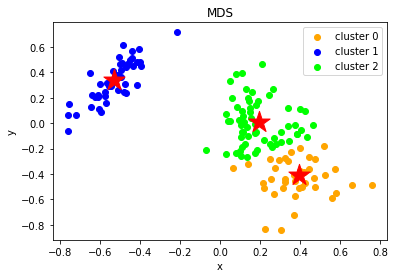

In [9]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

#### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [10]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

/Users/paulhickey/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/paulhickey/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


transformation complete


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

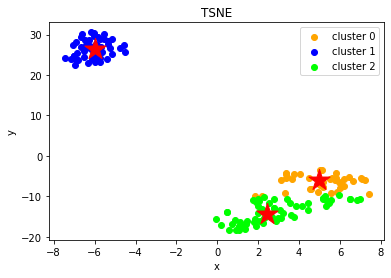

In [11]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### F. Cluster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [16]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [17]:
df.head()

sepallength  sepalwidth  petallength  petalwidth  cluster
0          5.1         3.5          1.4         0.2        1
1          4.9         3.0          1.4         0.2        1
2          4.7         3.2          1.3         0.2        1
3          4.6         3.1          1.5         0.2        1
4          5.0         3.6          1.4         0.2        1

In [18]:
df.tail()

sepallength  sepalwidth  petallength  petalwidth  cluster
145          6.7         3.0          5.2         2.3        0
146          6.3         2.5          5.0         1.9        2
147          6.5         3.0          5.2         2.0        0
148          6.2         3.4          5.4         2.3        0
149          5.9         3.0          5.1         1.8        2

#### Compute the mean value of each attribute for each cluster

In [19]:
df.groupby('cluster').mean()

sepallength  sepalwidth  petallength  petalwidth
cluster                                                  
0           6.846154    3.082051     5.702564    2.079487
1           5.006000    3.418000     1.464000    0.244000
2           5.888525    2.737705     4.396721    1.418033

#### Conclusion

By looking at the table above we can argue that:
* Cluster 2 are large iris flowers with the largest petals out of the three types.
* Cluster 0 are iris flowers with small petals (notably smaller than the other two types) but with wide sepals, the widest sepals of all three types. This is also the cluster that is clearly differentiated from the other two clusters in the scatter plots.
* Cluster 1 flowers are slightly smaller than cluster 2 flowers with a most notable difference in the width of the petals.

_Note that this conclusion is true for this run of k-Means. If the code is executed again, k-Means may produce either different clusters or the same clusters but in a different order._